In [55]:
#29/10/2021
#Importing necessary libraries

#importing data handling libraries
import pandas as pd
import numpy as np
from collections import OrderedDict

#importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#importing statistical libraries
import scipy.stats as sc
from statsmodels.stats.outliers_influence import variance_inflation_factor

#importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#importing machine learning libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor


#importing validation and model selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error


#importing libraries to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data
df = pd.read_excel('Capstone Project.xlsx')

In [3]:
#Viewing the data
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
#Looking at the descriptive statistics to get the better understanding of the data

def custom_summary(df):

    result =[]
    
    for col in list(df.columns):
        
        #Looking at the statistical parameters
        
        stats = OrderedDict({"featureName":col,
                            "count":df[col].count(),
                            "datatype":df[col].dtype,
                            "min":df[col].min(),
                            "Q1":df[col].quantile(0.25),
                            "Q2":df[col].quantile(0.5),
                            "Q3":df[col].quantile(0.75),
                            "Q4":df[col].quantile(1.0),
                            "mean":df[col].mean(),
                            "stdv":df[col].std(),
                            "var":df[col].var(),
                            "kurt":df[col].kurt(),
                            "skew":df[col].skew(),
                            "range":df[col].max() - df[col].min(),
                            "IQR": df[col].quantile(0.75) - df[col].quantile(0.25)
                            })
        
        # Checking the skewness of the data
        
        if df[col].skew()<-1.0:
            label = "Highly negatively skewed"
        elif -1.0<df[col].skew()<-0.5:
            label = "moderately negatively skewed"
        elif -0.5<df[col].skew()<0.5:
            label = "fairly symmetric"
        elif 0.5<df[col].skew()<1.0:
            label = "moderately positively skewed"
        else:
            label = "Highly positively skewed"
            
        stats['skewness comment'] = label;
        
        
        #Outliers identification
        
        upper_limit = stats['Q3'] + (1.5*stats['IQR'])
        lower_limit = stats['Q1'] - (1.5*stats['IQR'])
        if len([x for x in df[col] if x <lower_limit or x>upper_limit ]) > 0:
            outliers_label = "Has outliers"
        else:
            outliers_label = "No outliers"
        
        stats['Outlier comment'] = outliers_label        
        stats['number of outliers'] = len([x for x in df[col] if x <lower_limit or x>upper_limit ])
        
        #Calculating the outliers percentage
        
        stats['Percentage of outliers'] = stats['number of outliers']*100/stats['count']
        
        result.append(stats)
    resultdf = pd.DataFrame(data=result)
    return resultdf
    

In [5]:
custom_summary(df)

,featureName,count,datatype,min,Q1,Q2,Q3,Q4,mean,stdv,var,kurt,skew,range,IQR,skewness comment,Outlier comment,number of outliers,Percentage of outliers
0,cement,1030,float64,102.00,192.375,272.900,350.000,540.0,281.167864,104.506364,10921.580220,-0.520652,0.509481,438.00,157.625,moderately positively skewed,No outliers,0,0.000000
1,slag,1030,float64,0.00,0.000,22.000,142.950,359.4,73.895825,86.279342,7444.124812,-0.508175,0.800717,359.40,142.950,moderately positively skewed,Has outliers,2,0.194175
2,ash,1030,float64,0.00,0.000,0.000,118.300,200.1,54.188350,63.997004,4095.616541,-1.328746,0.537354,200.10,118.300,moderately positively skewed,No outliers,0,0.000000
3,water,1030,float64,121.80,164.900,185.000,192.000,247.0,181.567282,21.354219,456.002651,0.122082,0.074628,125.20,27.100,fairly symmetric,Has outliers,9,0.873786
4,superplastic,1030,float64,0.00,0.000,6.400,10.200,32.2,6.204660,5.973841,35.686781,1.411269,0.907203,32.20,10.200,moderately positively skewed,Has outliers,10,0.970874
5,coarseagg,1030,float64,801.00,932.000,968.000,1029.400,1145.0,972.918932,77.753954,6045.677357,-0.599016,-0.040220,344.00,97.400,fairly symmetric,No outliers,0,0.000000
6,fineagg,1030,float64,594.00,730.950,779.500,824.000,992.6,773.580485,80.175980,6428.187792,-0.102177,-0.253010,398.60,93.050,fairly symmetric,Has outliers,5,0.485437
7,age,1030,int64,1.00,7.000,28.000,56.000,365.0,45.662136,63.169912,3990.437729,12.168989,3.269177,364.00,49.000,Highly positively skewed,Has outliers,59,5.728155
8,strength,1030,float64,2.33,23.710,34.445,46.135,82.6,35.817961,16.705742,279.081814,-0.313725,0.416977,80.27,22.425,fairly symmetric,Has outliers,4,0.388350


Cement: It is moderately positively skewed.

Slag: Median and mean have high difference, need to remove outliers

Ash: moderately positively skewed. 50% of the data has 0 ash. The distribution is platykurtic

water: fairly symmetric and outliers to be removed.

superplastic: Leptokurtic distribution, moedrately skewed and outliers to be treated.

Courseagg: Data is almost perfect.

fineagg: Outliers to be treated.

age: Data seems to be from 1 year span. highly positively skewed. Outliers to be treated.

strength: DAta looks good for strength, outliers to be treated.

In [6]:
#Treating the outliers using outlier tretment function

def otf(data, col, method = 'Quartile', strategy= 'Median'):
    coldata = data[col]
    
    #Using Quartile method to identify the outliers
    if method == 'Quartile':
        median = coldata.median()
        Q1 = coldata.quantile(0.25)
        Q3 = coldata.quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + (1.5*IQR)
        lower_limit = Q1 - (1.5*IQR)
        
    #Using Standard deviation method to identify the outliers    
    elif method == 'std':
        colmean = coldata.mean()
        colstd = coldata.std()
        upper_limit = colmean + (2*colstd)
        lower_limit = colmean - (2*colstd)
        
    else:
        print('Invalid method')
             
    #Identifying the outliers        
    outlier = data.loc[(coldata < lower_limit) | (coldata > upper_limit), col]
    
    #Calculating outlier percentage
    outlier_percentage = round(len(outlier)*100/len(data), 2)
    
    
    if len(outlier) == 0:
        print(f"{col} doesn't have any outliers")
    else:
        print(f"Total number of outliers in {col} is {len(outlier)}")
        print(f'Percentage of outliers in {col} data is {outlier_percentage}')
    
    #Using median and mean strategy to replace outliers
    if strategy == 'Median':
        data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = median
    elif strategy == "Mean":
        data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = colmean
    return data
    

In [7]:
#Building ODT plots to understand outliers distribution

def odt_plots(df, col):
    fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,5))
    
    kwargs = {'fontsize':15, 'color':'black'}    #key word arguements
    
    #box plot with outliers
    sns.boxplot(df[col],ax=ax1,color = 'b')
    ax1.set_title('Box plot for '+col, **kwargs)
    ax1.set_xlabel('values', **kwargs)
    ax1.set_ylabel('Box distribution', **kwargs)
    
    #histogram with outliers
    sns.distplot(df[col],ax=ax2,color = 'r', fit=sc.norm)
    ax2.set_title('Histogram plot with outliers for '+col, **kwargs)
    ax2.set_xlabel('values', **kwargs)
    ax2.set_ylabel('Histrogram', **kwargs)
    
    #histogram with no outliers
    y = otf(df,col)
    sns.distplot(y[col], ax = ax3, color = 'y', fit=sc.norm)
    ax3.set_title('Histogram plot without outliers for '+col, **kwargs)
    ax3.set_xlabel('values', **kwargs)
    ax3.set_ylabel('Histrogram', **kwargs)

    plt.show()

cement doesn't have any outliers


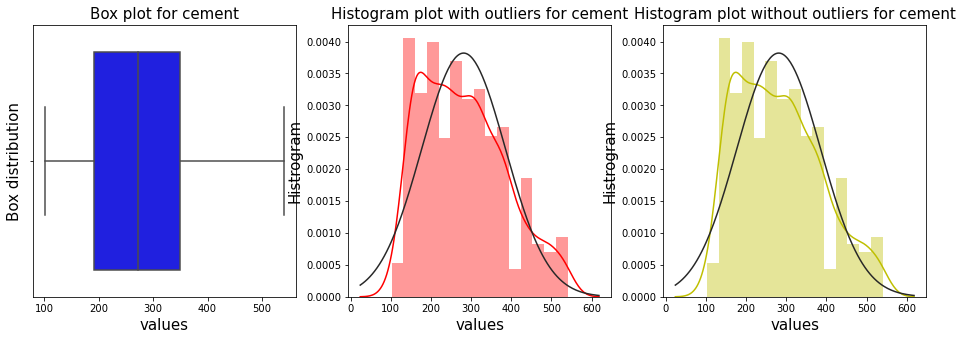

Total number of outliers in slag is 2
Percentage of outliers in slag data is 0.19


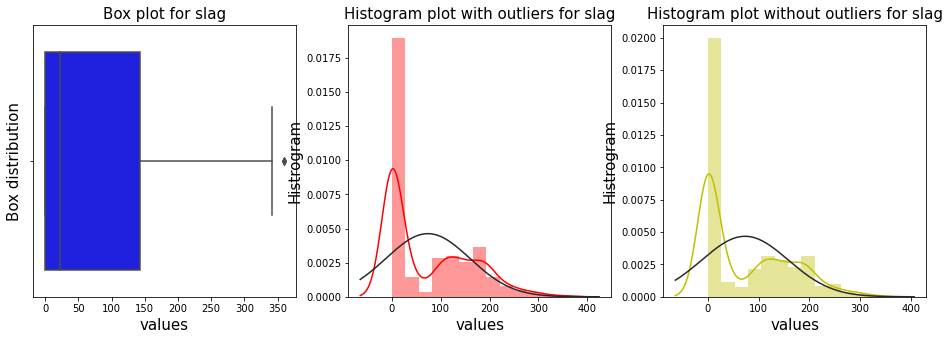

ash doesn't have any outliers


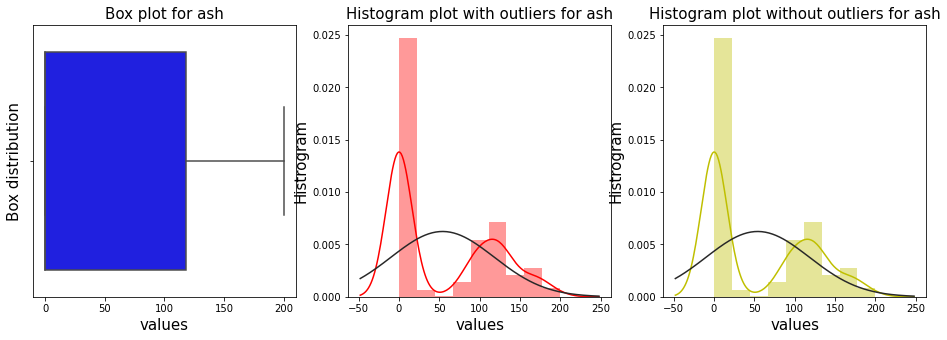

Total number of outliers in water is 9
Percentage of outliers in water data is 0.87


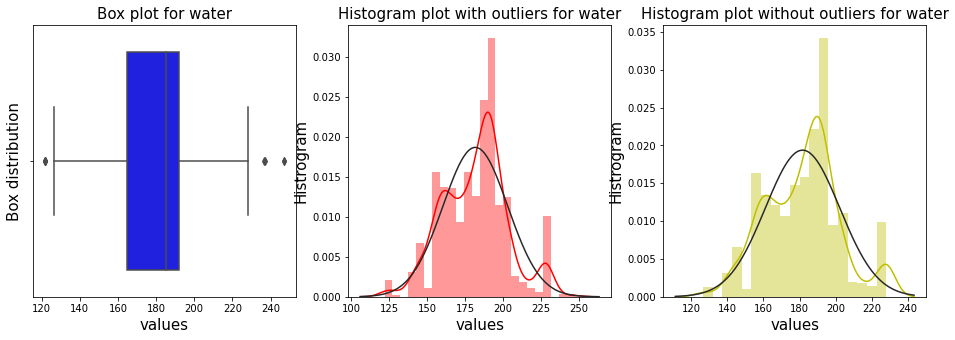

Total number of outliers in superplastic is 10
Percentage of outliers in superplastic data is 0.97


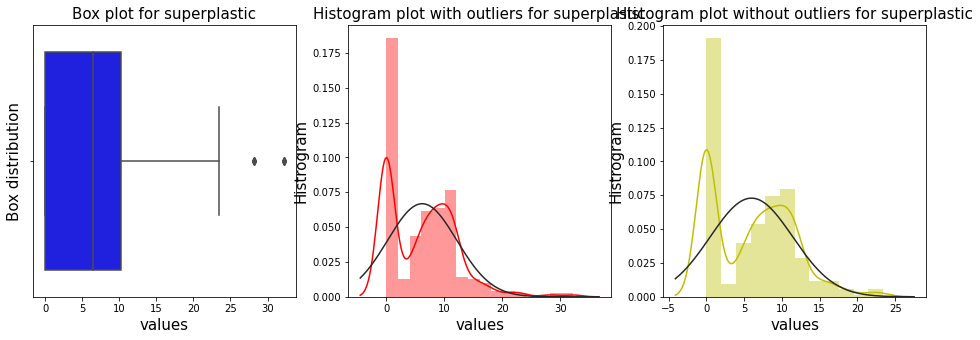

coarseagg doesn't have any outliers


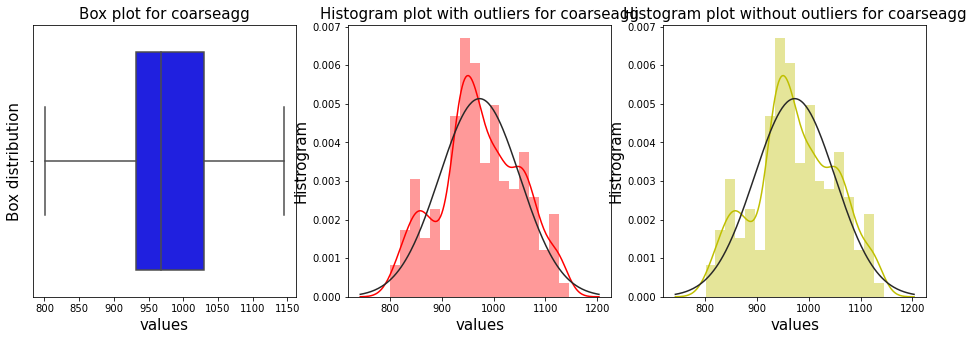

Total number of outliers in fineagg is 5
Percentage of outliers in fineagg data is 0.49


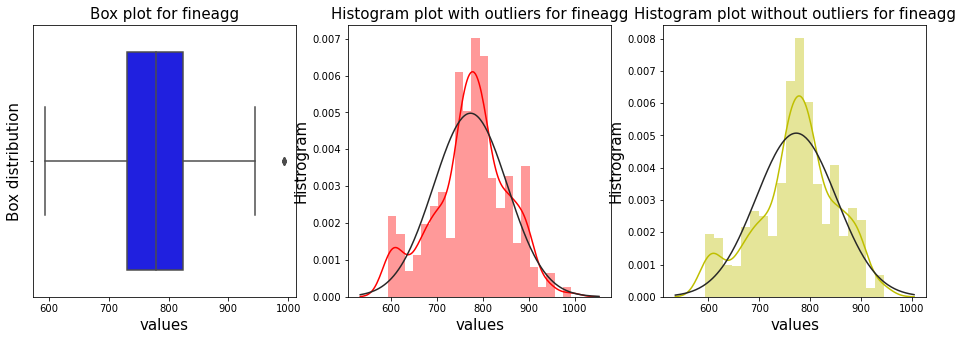

Total number of outliers in age is 59
Percentage of outliers in age data is 5.73


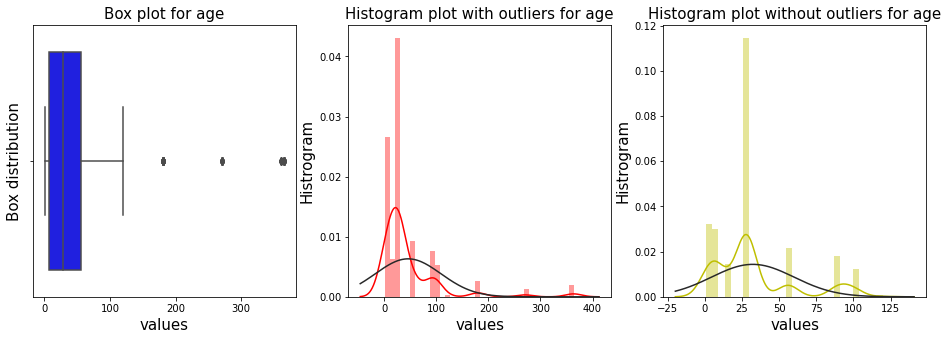

Total number of outliers in strength is 4
Percentage of outliers in strength data is 0.39


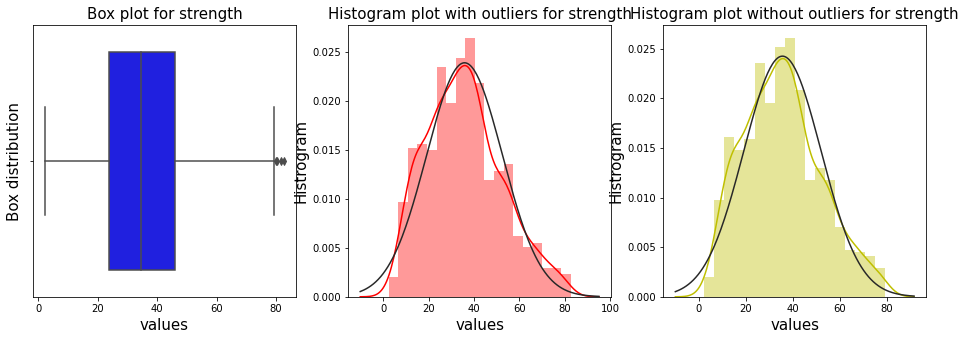

In [8]:
for col in df.columns:
    odt_plots(df, col)

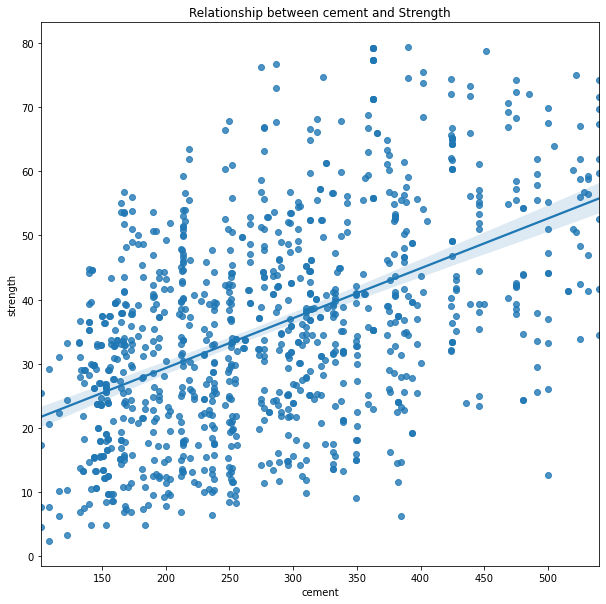

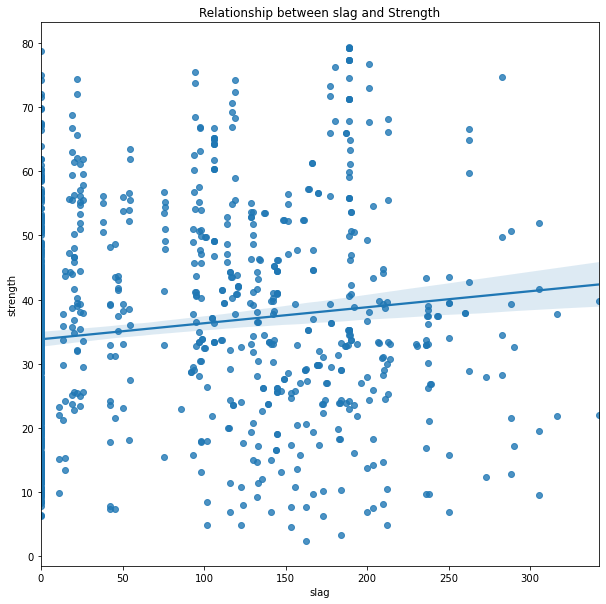

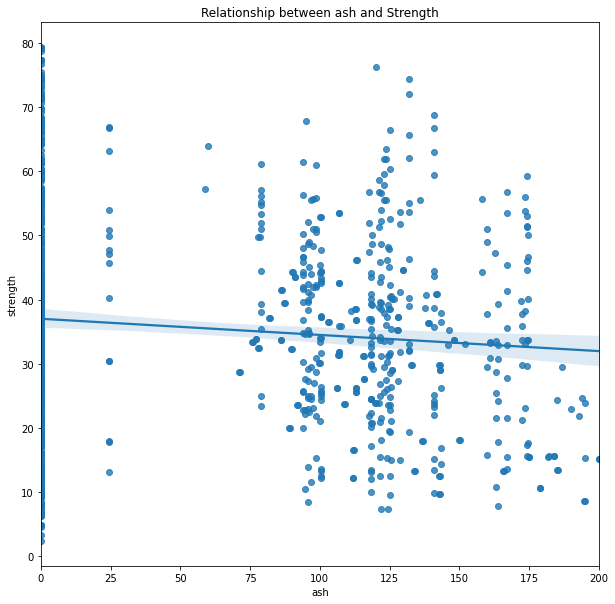

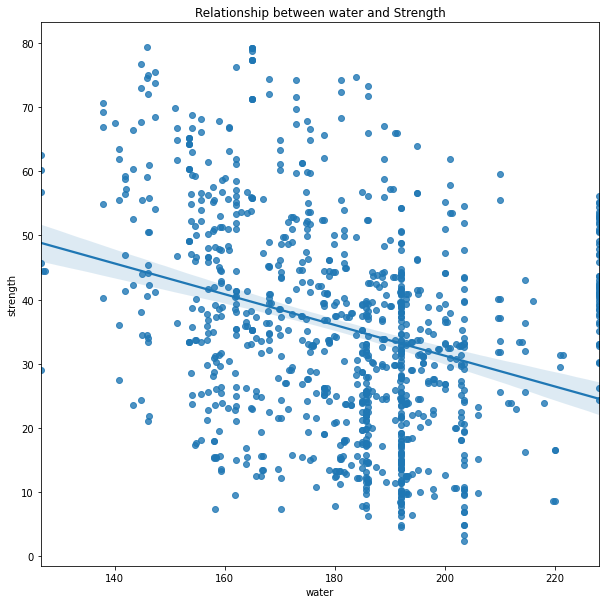

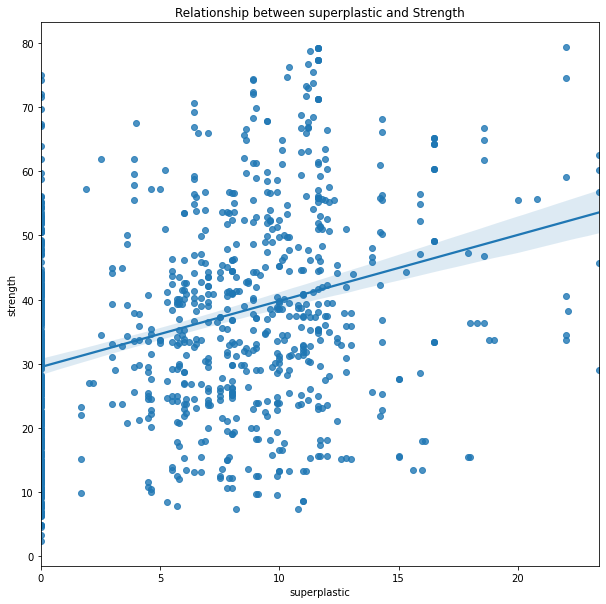

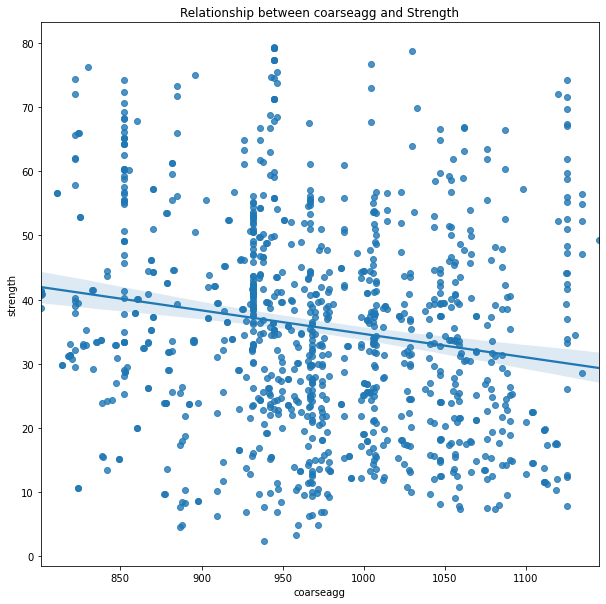

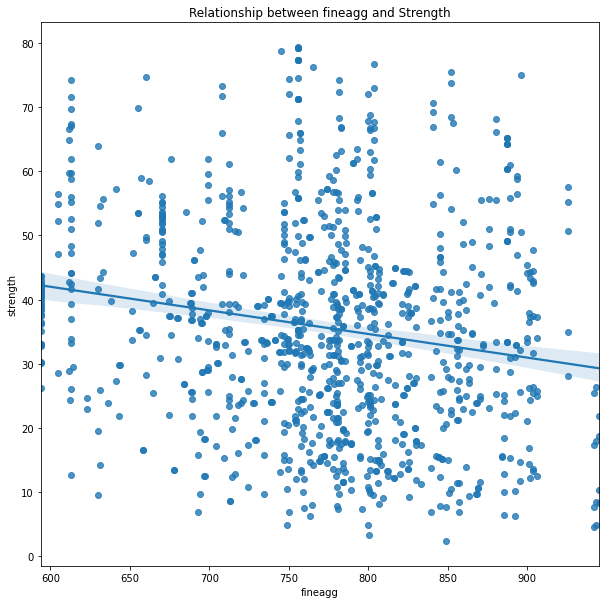

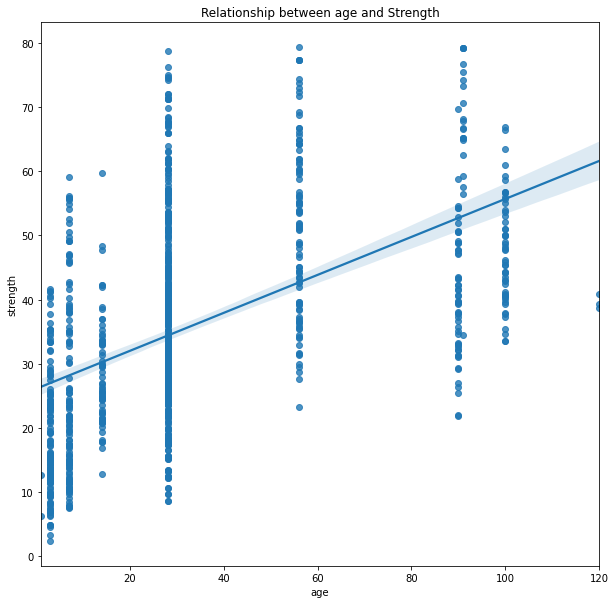

In [9]:
#Finding the relationship between the dependent and the independent variables (Correlation) (with regression plots)
for col in list(df.columns):
    if col != 'strength':
        f,ax1 = plt.subplots(figsize = (10,10))
        sns.regplot(x = df[col], y=df['strength'], ax=ax1).set_title(f'Relationship between {col} and Strength')

cement: positively correlated
slag: slight positively correlated
ash: slight negatively correlated
water: negative
super plastic: positive
coarseagg: negative
fineagg: negative
age:positive

In [10]:
#Finding out the correlation with the target (correlation matrix)
def corr_variables(data, target):
    ind_var = data.drop([target], axis=1).columns
    corr_res =[]
    for col in ind_var:
        corr_res.append(data[target].corr(data[col]))
    res_df = pd.DataFrame([ind_var, corr_res], index=['variable','correlation']).T.sort_values('correlation', ascending = False)
    
    return res_df

In [11]:
corr_variables(df, 'strength')

,variable,correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


sequence is
age > cement > superplastic > water > fineagg > coarseagg> slag > ash

<AxesSubplot:>

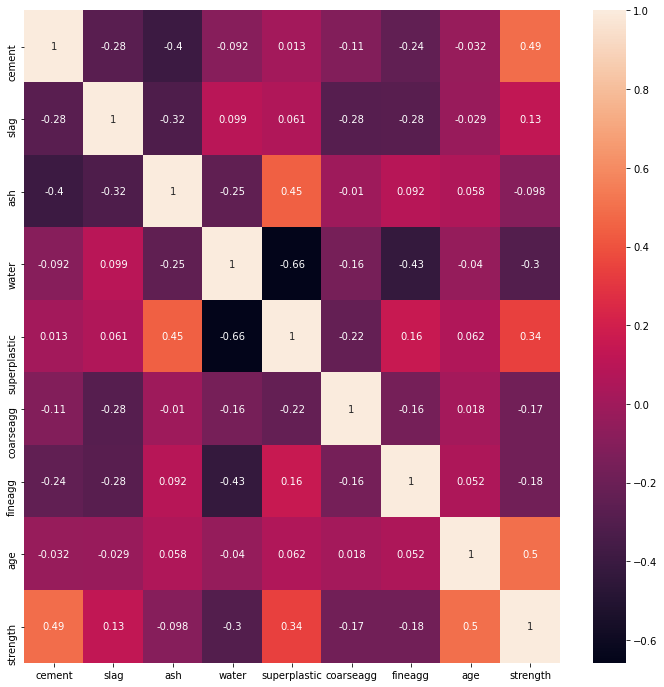

In [12]:
# Multicolinearity check (with heat map)
corr = df.corr()
fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

cement: ash (0.4)
slag: ash (0.4)
ash: superplastic (0.45)
water: fineagg (0.43), super plastic(0.66)


In [13]:
# Multicolinearity check with VIF
# Another method of checking multicolinearity is by using VIF (variance inflation factor)
# VIF = 1/(1-r^2)
# If the VIF value is more than 5, then we say multicolinearity exists
# Steps 
# 1. Regress every independent variable with all others and find the r^2
# 2. Calculate the VIF using the above formula

In [14]:
def vif_colinearity(data, target):
    ind_var = data.drop([target], axis=1)
    vif = pd.DataFrame()
    vif['vif factor'] = [variance_inflation_factor(ind_var.values,i) for i in range(ind_var.shape[1])]
    vif['variable'] = ind_var.columns
    
    return vif.sort_values('vif factor', ascending=False)

In [15]:
vif_colinearity(df, 'strength')

,vif factor,variable
5,86.938582,coarseagg
3,81.963087,water
6,68.664404,fineagg
0,14.291158,cement
4,5.724145,superplastic
2,4.415840,ash
1,3.342314,slag
7,2.368372,age


In [16]:
#01/11/2021
# As the above variables has have multicolinearity, we will apply PCA
def apply_pca(x):
    col = []
    n_comp = len(x.columns)
    
    #applying standard scalar before PCA
    x = StandardScaler().fit_transform(x)
    
    #Applying PCA in for floop
    for i in range(1,n_comp):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1]>0.9:
            n_components = i
            break
    
    print("The explained variance ratio is: ", evr)
    
    #creating data frame
    for j in range(1,n_components+1):
        col.append('pc'+str(j))
        
    result = pd.DataFrame(data = p_comp, columns=col)
    return result

In [17]:
pca_df = apply_pca(df.drop('strength', axis=1))

The explained variance ratio is:  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [18]:
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228
...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321


In [19]:
pca_df = pca_df.join(df[['strength']], how='left')

In [20]:
#pca_df
vif_colinearity(pca_df, 'strength')

,vif factor,variable
5,1.0,pc6
0,1.0,pc1
2,1.0,pc3
3,1.0,pc4
4,1.0,pc5
1,1.0,pc2


In [21]:
def train_n_test_split(data, target, test_size=0.3):
    x=data.drop(target, axis=1)
    y=df[[target]]
    
    return train_test_split(x,y, test_size=test_size,random_state=50)

In [22]:
def build_model(model_name, estimator, data, target):
    x_train, x_test, y_train, y_test = train_n_test_split(data, target)
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    rmsc = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    
    temp = [model_name, rmsc, r2score]
    return temp

In [23]:
build_model('Linear regression', LinearRegression(), pca_df, 'strength')

['Linear regression', 9.171767967837699, 0.7100371520298293]

In [24]:
def multiple_models(data, target):
    
    #column names in empty data frame
    col_names = ['Model name', 'rmsc', 'r2score']
    
    #Creating a empty data frame
    resultdf = pd.DataFrame(columns=col_names)
    
    resultdf.loc[len(resultdf)] = build_model('Linear regression', LinearRegression(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Lasso', Lasso(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ridge', Ridge(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Decision tree', DecisionTreeRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('KNN', KNeighborsRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('SVM regressor', SVR(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('randon forests', RandomForestRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ada boost', AdaBoostRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Gboost', GradientBoostingRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('xGboost', XGBRegressor(), data, target)
    
    return resultdf
    
    

In [25]:
multiple_models(pca_df, 'strength')

,Model name,rmsc,r2score
0,Linear regression,9.171768,0.710037
1,Lasso,9.625852,0.680615
2,Ridge,9.173294,0.709941
3,Decision tree,7.113288,0.825588
4,KNN,8.223228,0.766911
5,SVM regressor,9.438373,0.692935
6,randon forests,6.096020,0.871906
7,Ada boost,8.363572,0.758887
8,Gboost,6.692121,0.845630
9,xGboost,6.095381,0.871933


In [26]:
#02/11/2021
#Cross validation score
def cv_score(x,y,fold=10):
    
    #defining cross validation score
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_lasso = cross_val_score(Lasso(),x,y,cv=fold)
    score_ridge = cross_val_score(Ridge(),x,y,cv=fold)
    score_DT = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_KNN = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svm = cross_val_score(SVR(),x,y,cv=fold)
    score_RF = cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_ADR = cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_GBR = cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xGBR = cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    model_names = ['Linear Regression', 'Lasso regression', 'Ridge', 'Decision tree', 'kNeighbors', 'SVM', 'Random forests', 'Ada boost', 'Gradient boost', 'xGBoost']
    scores = [score_lr, score_lasso, score_ridge, score_DT, score_KNN, score_svm, score_RF, score_ADR, score_GBR, score_xGBR]
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        n_names = model_names[i]
        temp = [n_names, score_mean, score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(data=result, columns=['model_names', 'average score', 'standard deviation'])
    
    return result_df
    

In [27]:
cv_score(pca_df.drop('strength', axis=1), pca_df[['strength']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.663928,0.059476
1,Lasso regression,0.649837,0.049887
2,Ridge,0.663935,0.059437
3,Decision tree,0.760608,0.062643
4,kNeighbors,0.767929,0.055767
5,SVM,0.703117,0.042765
6,Random forests,0.868212,0.033031
7,Ada boost,0.730787,0.038428
8,Gradient boost,0.828944,0.050156
9,xGBoost,0.873262,0.036061


In [28]:
#Hyper parameter tuning using grid search CV
def tuning_models(x,y,fold=10):
    params_las = {'alpha':[1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 0.0001,0.001,0.01, 0.1, 0, 1]}
    params_rd = {'alpha':[1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 0.0001,0.001,0.01, 0.1, 0, 1]}
    params_rf = {'n_estimators':[5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    params_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]}
    params_adb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    params_gb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    params_xgb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100],
                 'gamma': [10,20,30,40,50,60,70,80,90,100]}
    
    
    tune_lasso = GridSearchCV(Lasso(), params_las, cv=fold)
    tune_ridge = GridSearchCV(Ridge(), params_rd, cv=fold)
    tune_rf = GridSearchCV(RandomForestRegressor(), params_rf, cv=fold)
    tune_knn = GridSearchCV(KNeighborsRegressor(), params_knn, cv=fold)
    tune_adb = GridSearchCV(AdaBoostRegressor(), params_adb, cv=fold)
    tune_gb = GridSearchCV(GradientBoostingRegressor(), params_gb, cv=fold)
    tune_xgb = GridSearchCV(XGBRegressor(), params_xgb, cv=fold)
    
    tune_lasso.fit(x,y)
    tune_ridge.fit(x,y)
    tune_rf.fit(x,y)
    tune_knn.fit(x,y)
    tune_adb.fit(x,y)
    tune_gb.fit(x,y)
    tune_xgb.fit(x,y)
    
    tune = [tune_lasso, tune_ridge, tune_rf, tune_knn, tune_adb, tune_gb, tune_xgb]
    model_names = ['Lasso regression', 'Ridge', 'Random forests', 'KNeighbors', 'Ada boost', 'Gradient boost', 'xGBoost']
    
    
    for i in range(0,len(tune)):
        print('Model', model_names[i])
        print('Best parameters', tune[i].best_params_ )
    

In [29]:
#tuning_models(pca_df.drop('strength', axis=1), pca_df[['strength']])

In [30]:
#03/11/2021
def cv_score_tuned(x,y,fold=10):
    
    #defining cross validation score
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_lasso = cross_val_score(Lasso(alpha=0.1),x,y,cv=fold)
    score_ridge = cross_val_score(Ridge(alpha=1.0),x,y,cv=fold)
    score_DT = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_KNN = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svm = cross_val_score(SVR(),x,y,cv=fold)
    score_RF = cross_val_score(RandomForestRegressor(n_estimators=100),x,y,cv=fold)
    score_ADR = cross_val_score(AdaBoostRegressor(learning_rate=0.7, n_estimators=60),x,y,cv=fold)
    score_GBR = cross_val_score(GradientBoostingRegressor(learning_rate=0.3, n_estimators=100),x,y,cv=fold)
    score_xGBR = cross_val_score(XGBRegressor(gamma=10, learning_rate=0.2, n_estimators=100),x,y,cv=fold)
    
    model_names = ['Linear Regression', 'Lasso regression', 'Ridge', 'Decision tree', 'kNeighbors', 'SVM', 'Random forests', 'Ada boost', 'Gradient boost', 'xGBoost']
    scores = [score_lr, score_lasso, score_ridge, score_DT, score_KNN, score_svm, score_RF, score_ADR, score_GBR, score_xGBR]
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        n_names = model_names[i]
        temp = [n_names, score_mean, score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(data=result, columns=['model_names', 'average score', 'standard deviation'])
    
    return result_df

In [31]:
cv_score_tuned(pca_df.drop('strength', axis=1), pca_df[['strength']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.663928,0.059476
1,Lasso regression,0.664143,0.058426
2,Ridge,0.663935,0.059437
3,Decision tree,0.762788,0.062249
4,kNeighbors,0.767929,0.055767
5,SVM,0.703117,0.042765
6,Random forests,0.867582,0.031336
7,Ada boost,0.728438,0.034760
8,Gradient boost,0.858195,0.049548
9,xGBoost,0.870348,0.035349


<AxesSubplot:xlabel='cement', ylabel='strength'>

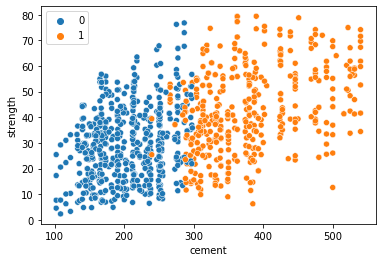

In [32]:
#applying clustering in order to see if the accuracy increases

x=df.drop('strength', axis=1)
y=df[['strength']]

from sklearn.cluster import KMeans

labels = KMeans(n_clusters=2, random_state=100).fit_predict(x)
sns.scatterplot(x=x.cement, y=y.strength, hue=labels)

In [33]:
def clusters_in_data(x,target, labels):
    columns = list(set(list(x.columns))-set(target))
    r = int(len(columns)/2)
    
    
    
    if r%2 == 0:
        r=r
    else:
        r=r+1
        
    
    f, ax = plt.subplots(r,2, figsize=(15,15))
    a=0
    for row in range(0,r):
        for col in range(0,2):
            if a != len(columns):
                ax[row][col].scatter(x[target], x[columns[a]], c=labels)
                ax[row][col].set_xlabel(target)
                ax[row][col].set_ylabel(columns[a])
                a=a+1

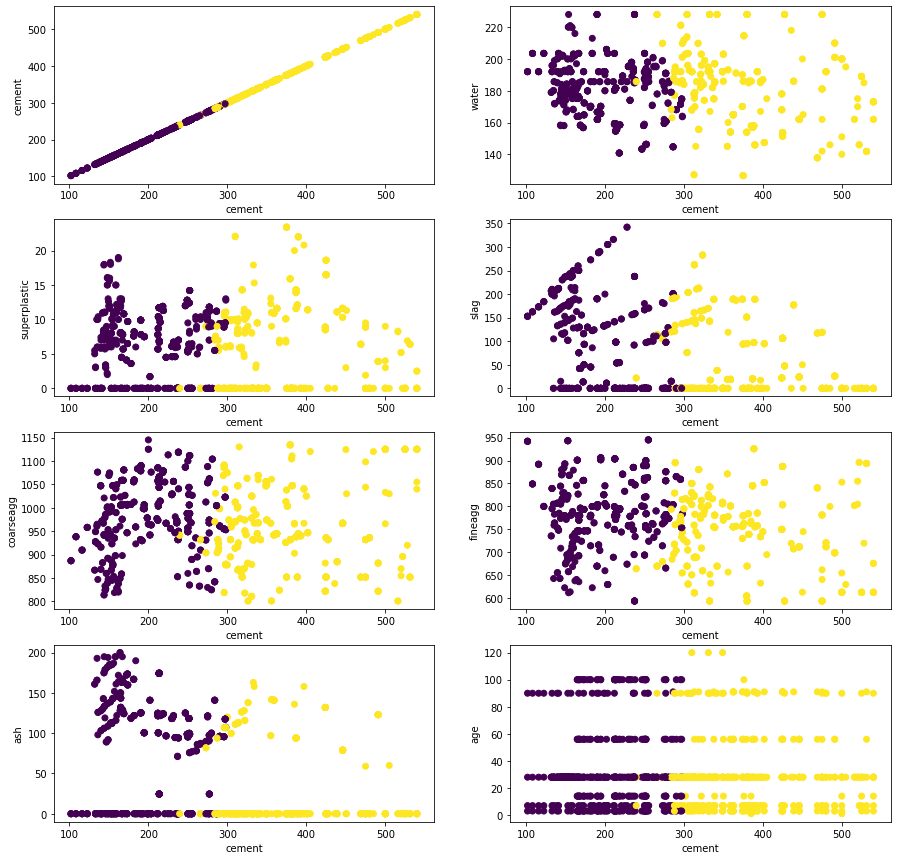

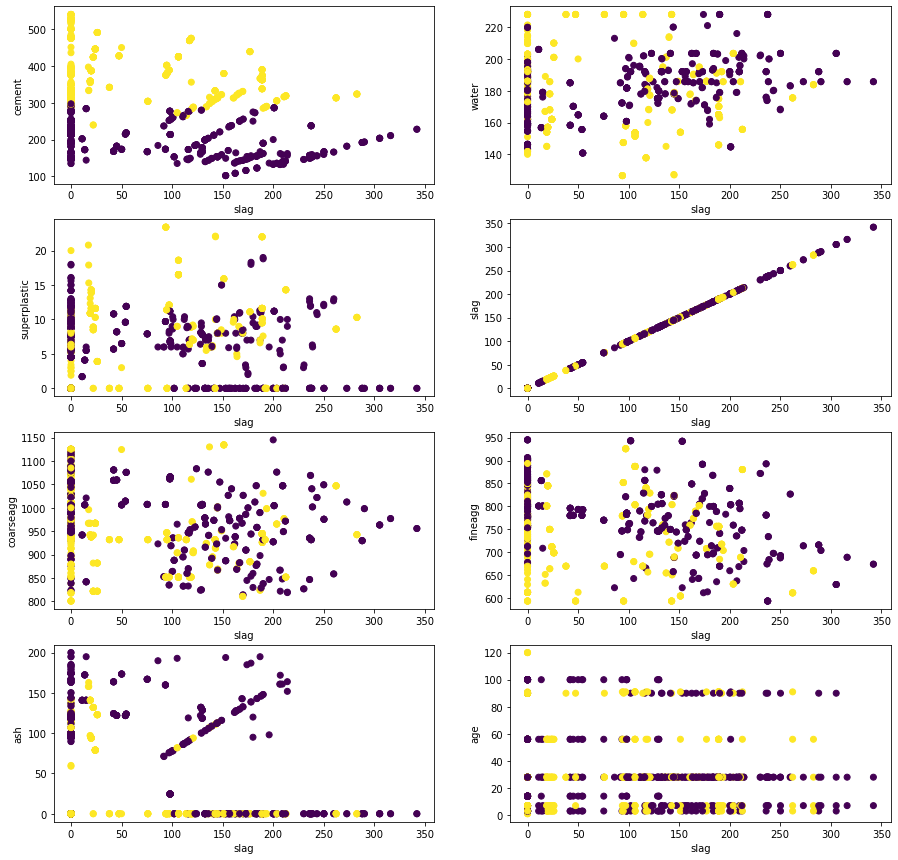

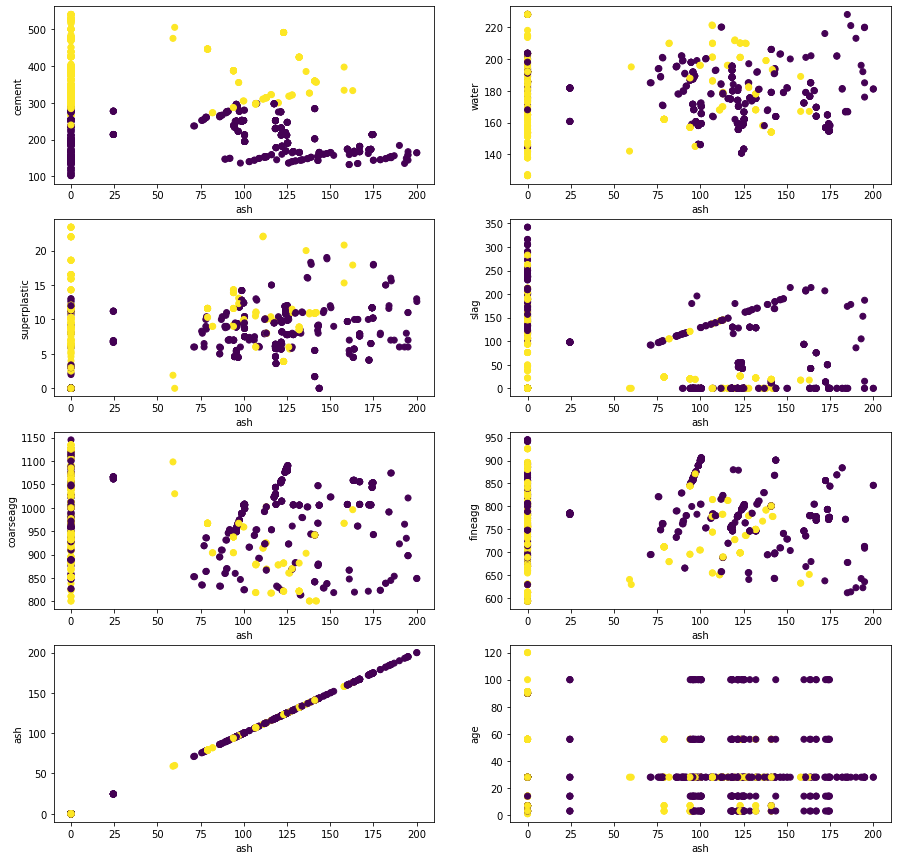

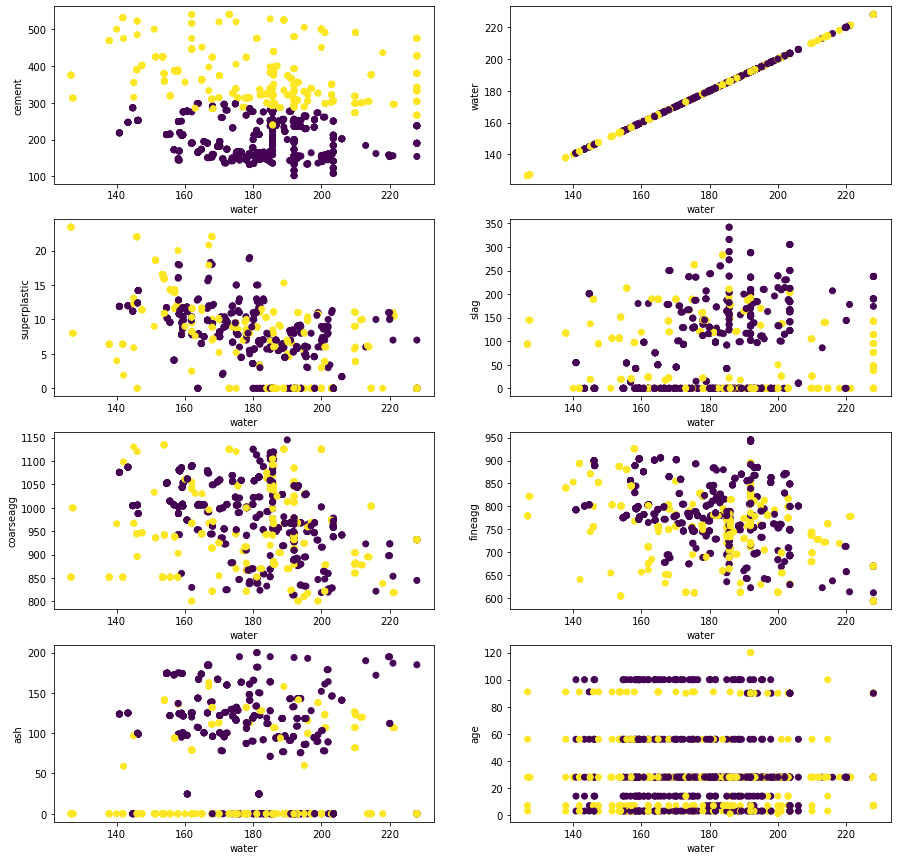

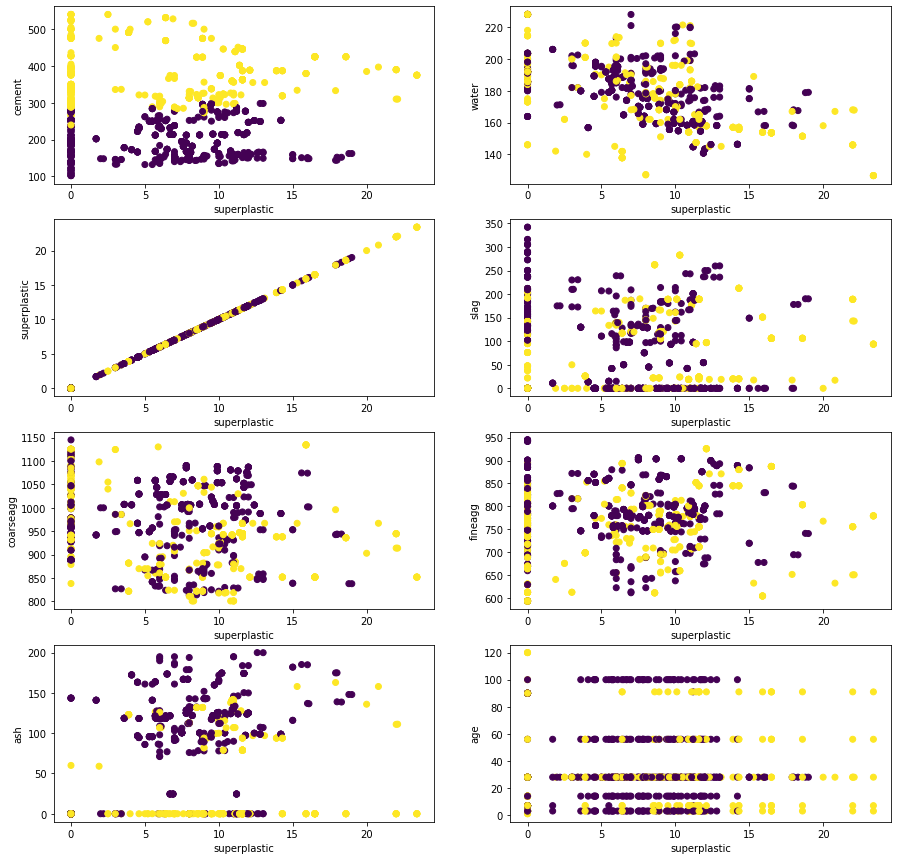

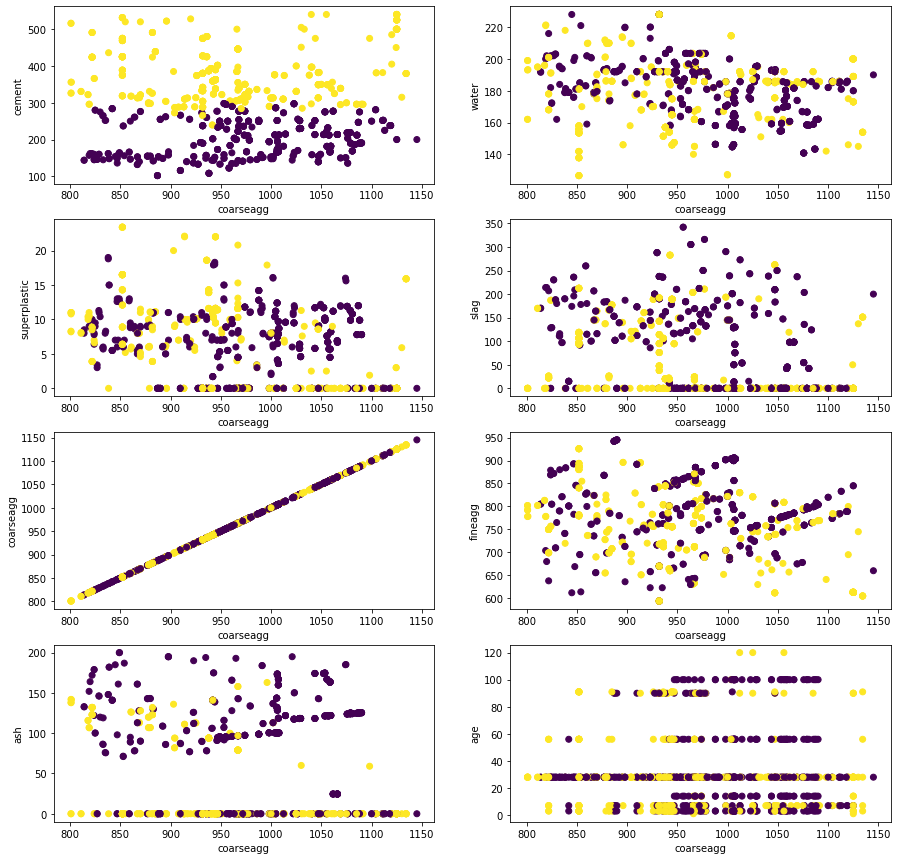

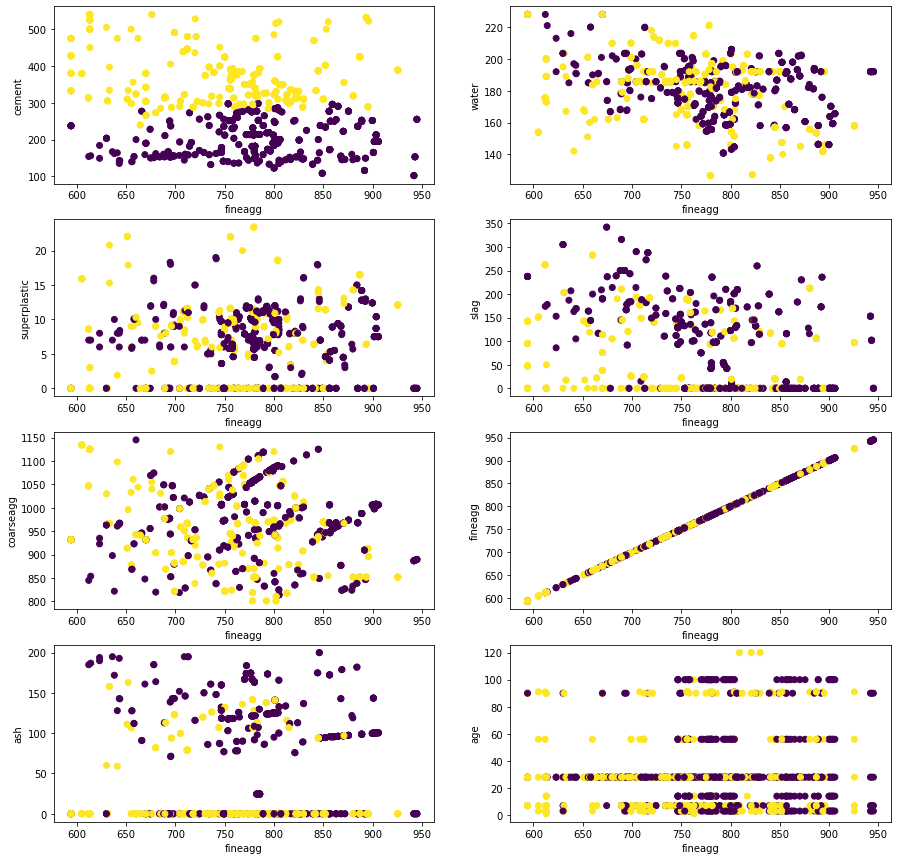

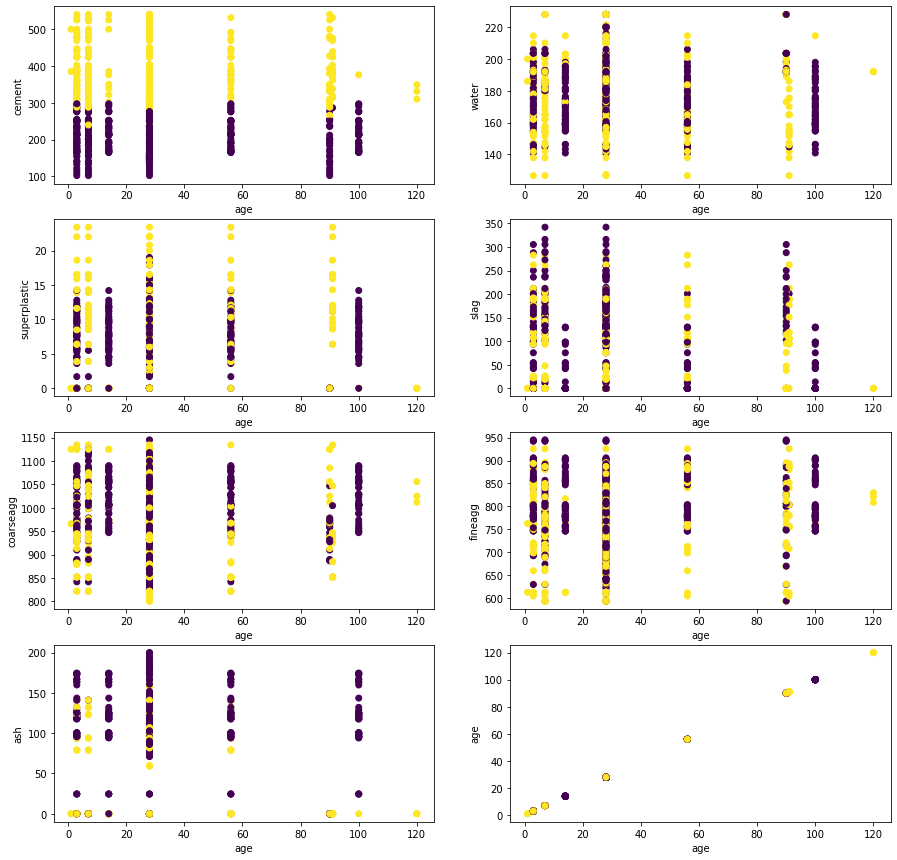

In [34]:
for col in x.columns:
    clusters_in_data(x, col, labels)

In [35]:
#Analysis: From the above graphs we see that cement has clusters with all other variables.

In [36]:
clustered_df = df.join(pd.DataFrame(labels, columns=['labels']), how='left')

In [37]:
clustered_df


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,labels
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,0
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,1


In [38]:
new_feature = clustered_df.groupby('labels')['cement'].agg(['mean', 'median'])

In [39]:
new_feature

,mean,median
labels,,
0,203.132804,202.0
1,376.731317,362.6


In [40]:
clustered_df = clustered_df.merge(new_feature, on='labels', how='left')

In [41]:
clustered_df = clustered_df.drop('labels', axis=1)

In [42]:
clustered_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,203.132804,202.0
...,...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,203.132804,202.0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,376.731317,362.6
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,203.132804,202.0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,376.731317,362.6


In [43]:
cv_score_tuned(clustered_df.drop('strength', axis=1), clustered_df[['strength']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.686818,0.062169
1,Lasso regression,0.686641,0.062319
2,Ridge,0.686641,0.062314
3,Decision tree,0.836380,0.054554
4,kNeighbors,0.669395,0.088242
5,SVM,0.246843,0.044778
6,Random forests,0.886567,0.032641
7,Ada boost,0.741384,0.033099
8,Gradient boost,0.886724,0.058647
9,xGBoost,0.898677,0.042637


# Feature Engineering

In [45]:
x_train, x_test, y_train, y_test = train_test_split(clustered_df.drop('strength', axis=1), clustered_df[['strength']], test_size=0.3)

In [46]:
xgb = XGBRegressor()

In [47]:
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

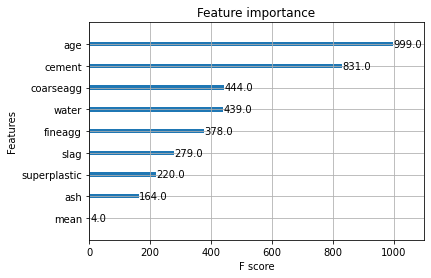

In [49]:
xgboost.plot_importance(xgb)

In [51]:
temp_df = clustered_df[['age', 'cement', 'coarseagg', 'water', 'fineagg']]

In [52]:
cv_score_tuned(temp_df, clustered_df[['strength']])

,model_names,average score,standard deviation
0,Linear Regression,0.657579,0.060465
1,Lasso regression,0.657583,0.060431
2,Ridge,0.657579,0.060465
3,Decision tree,0.809884,0.066247
4,kNeighbors,0.645391,0.079298
5,SVM,0.252828,0.044987
6,Random forests,0.865155,0.038828
7,Ada boost,0.700760,0.039075
8,Gradient boost,0.870089,0.051155
9,xGBoost,0.876724,0.041177


In [53]:
temp_df = clustered_df[['age', 'cement', 'coarseagg', 'water']]

In [54]:
cv_score_tuned(temp_df, clustered_df[['strength']])

,model_names,average score,standard deviation
0,Linear Regression,0.570613,0.066400
1,Lasso regression,0.570620,0.066342
2,Ridge,0.570613,0.066400
3,Decision tree,0.735917,0.084460
4,kNeighbors,0.662576,0.066705
5,SVM,0.270158,0.045718
6,Random forests,0.841394,0.044432
7,Ada boost,0.678293,0.034900
8,Gradient boost,0.848053,0.042853
9,xGBoost,0.864152,0.043254


# Learning curve analysis

In [59]:
def learning_curve_analysis(model_name, estimator, x, y):
    train_size, train_score, test_score = learning_curve(estimator, X=x, y=y, cv=10)
    train_score_mean = np.mean(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    plt.plot(train_size, train_score_mean, color='red')
    plt.plot(train_size, test_score_mean, color='green')
    plt.xlabel('samples')
    plt.ylabel('accuracy score')
    plt.title('Learning curve for '+model_name)
    plt.legend(['train_score', 'test_score'])

In [60]:
x, y=temp_df,clustered_df[['strength']]

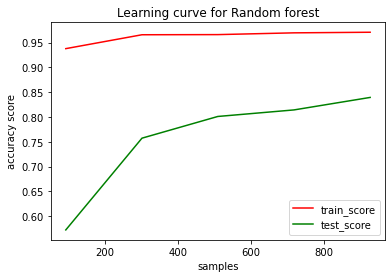

In [61]:
learning_curve_analysis('Random forest', RandomForestRegressor(), x, y)

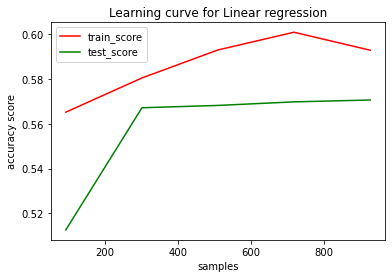

In [62]:
learning_curve_analysis('Linear regression', LinearRegression(), x, y)

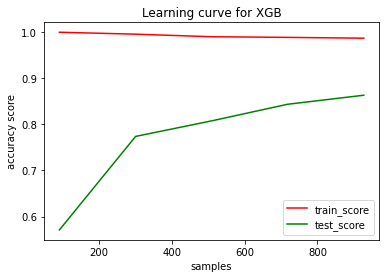

In [63]:
learning_curve_analysis('XGB', XGBRegressor(), x, y)